# Imports

In [1]:
#for importing code
import sys, os
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    print(f"Adding {module_path} to sys.path")
    sys.path.append(module_path)

Adding /Users/yonatanlou/dev/meaningful-transparency/src to sys.path


In [2]:
import pandas as pd
from constants import PROJECT_ROOT

# created by: uv run python src/classify_twitter_posts.py --model anthropic/claude-sonnet-4 --temperature 0.1 --n-samples 750 --min-chars 50 --results_filename twitter_posts_classified
both_def_path = (
    f"{PROJECT_ROOT}/outputs/twitter_posts_classified_2025-09-06-H:19-M:31.csv"
)
df = pd.read_csv(both_def_path)
df = df.rename(columns={"biased": "is_antisemitic"})
df["prediction_both_def"] = df["prediction"].fillna("None")
df["predicted_antisemitic_both_def"] = (
    df["prediction"].isin(
        ["IHRA Definition", "Jerusalem Declaration + IHRA Definition"]
    )
).astype(bool)

# uv run python src/classify_twitter_posts.py --model anthropic/claude-sonnet-4 --temperature 0.1 --n-samples 750 --min-chars 50 --results_filename twitter_posts_classified_IHRA --one-def "IHRA Definition" 
IHRA_df = pd.read_csv(
    f"{PROJECT_ROOT}/outputs/twitter_posts_classified_IHRA_2025-09-07-H:11-M:11.csv"
)
IHRA_df = IHRA_df.rename(columns={"prediction": "prediction_IHRA", "description": "description_IHRA"})

# uv run python src/classify_twitter_posts.py --model anthropic/claude-sonnet-4 --temperature 0.1 --n-samples 750 --min-chars 50 --results_filename twitter_posts_classified_JD --one-def "Jerusalem Declaration"
JD_df = pd.read_csv(
    f"{PROJECT_ROOT}/outputs/twitter_posts_classified_JD_2025-09-07-H:12-M:31.csv"
)
JD_df = JD_df.rename(columns={"prediction": "prediction_JD", "description": "description_JD"})
merged_df = pd.merge(df, IHRA_df[["original_index","prediction_IHRA", "description_IHRA"]], on="original_index")
merged_df = pd.merge(merged_df, JD_df[["original_index","prediction_JD", "description_JD"]], on="original_index")
merged_df.info()

merged_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   original_index                  750 non-null    int64  
 1   text                            750 non-null    object 
 2   is_antisemitic                  750 non-null    int64  
 3   keyword                         750 non-null    object 
 4   prediction                      434 non-null    object 
 5   description                     750 non-null    object 
 6   model                           750 non-null    object 
 7   max_tokens                      750 non-null    int64  
 8   temperature                     750 non-null    float64
 9   usage                           749 non-null    object 
 10  prediction_both_def             750 non-null    object 
 11  predicted_antisemitic_both_def  750 non-null    bool   
 12  prediction_IHRA                 750 

,original_index,text,is_antisemitic,keyword,prediction,description,model,max_tokens,temperature,usage,prediction_both_def,predicted_antisemitic_both_def,prediction_IHRA,description_IHRA,prediction_JD,description_JD
0,5310,RT : A core part of my Jewish education growi...,0,Jews,NaN,This text expresses a Jewish person's perspect...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4774, 'completion_tokens': 7...",None,False,False,This text expresses criticism of Israeli polic...,False,This text expresses a Jewish person's perspect...
1,838,President DELIVERS yet another breakthrough f...,0,Israel,NaN,This text celebrates a diplomatic achievement ...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4772, 'completion_tokens': 6...",None,False,False,This text celebrates a peace agreement between...,False,This text celebrates diplomatic achievements r...
2,3518,Totally creepy. Deep down think they hate Jews...,0,Jews,NaN,The text expresses suspicion about a group's m...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4756, 'completion_tokens': 7...",None,False,False,This text appears to be criticizing a particul...,False,This text expresses suspicion about a group's ...
3,1333,U.S. Virgin Islands (????)\n+\nIsrael (????)\...,0,Israel,NaN,This appears to be a simple wordplay or pun co...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4762, 'completion_tokens': 9...",None,False,False,This text appears to be a simple wordplay comb...,False,This text appears to be making a play on words...
4,5843,Very distressing but not surprising considerin...,0,Jews,NaN,The text expresses concern about antisemitism ...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4764, 'completion_tokens': 6...",None,False,False,This text expresses concern about antisemitism...,False,This text expresses concern about antisemitism...


# Data Config:
- model: anthropic/claude-sonnet-4 
- temperature 0.1 
- n-samples 750
- min-chars 50 
- Antisemitism samples: 525
- Non-Antisemitism samples: 225

# Cost

In [3]:
import json
import pandas as pd
import ast


# Try different parsing methods
def safe_parse_usage(usage_str):
    try:
        # Try JSON first
        return json.loads(usage_str)
    except Exception:
        try:
            # Try ast.literal_eval for Python dict strings
            return ast.literal_eval(usage_str)
        except Exception:
            try:
                # Try eval as last resort (if it's a Python dict)
                return eval(usage_str)
            except Exception:
                return None

def print_costs(df_origin):
    df = df_origin.copy()
    # Parse the usage column
    df["usage_parsed"] = df["usage"].apply(safe_parse_usage)

    # Check how many failed to parse
    failed_count = df["usage_parsed"].isnull().sum()
    print(f"Failed to parse: {failed_count} rows out of {len(df)}")

    # Extract token counts (handle None values)
    df["prompt_tokens"] = df["usage_parsed"].apply(lambda x: x["prompt_tokens"] if x else 0)
    df["completion_tokens"] = df["usage_parsed"].apply(
        lambda x: x["completion_tokens"] if x else 0
    )
    df["total_tokens"] = df["usage_parsed"].apply(lambda x: x["total_tokens"] if x else 0)

    # Calculate totals
    total_prompt_tokens = df["prompt_tokens"].sum()
    total_completion_tokens = df["completion_tokens"].sum()
    total_tokens = df["total_tokens"].sum()

    # Claude Sonnet 4 pricing: $3/M input, $15/M output
    input_cost = (total_prompt_tokens / 1_000_000) * 3
    output_cost = (total_completion_tokens / 1_000_000) * 15
    total_cost = input_cost + output_cost

    print(f"Total Prompt Tokens: {total_prompt_tokens:,}")
    print(f"Total Completion Tokens: {total_completion_tokens:,}")
    print(f"Total Tokens: {total_tokens:,}")
    print("\nCost Breakdown:")
    print(f"Input Cost: ${input_cost:.4f}")
    print(f"Output Cost: ${output_cost:.4f}")
    print(f"Total Cost: ${total_cost:.4f}")

# for tmp_df in [df, IHRA_df, JD_df]:
for name, tmp_df in {"Both definitions": df, "IHRA only": IHRA_df, "JD only": JD_df}.items(): 
    print(f"--- Costs for {name} ---")
    print_costs(tmp_df)
    print("\n")

--- Costs for Both definitions ---
Failed to parse: 1 rows out of 750
Total Prompt Tokens: 3,572,984
Total Completion Tokens: 63,256
Total Tokens: 3,636,240

Cost Breakdown:
Input Cost: $10.7190
Output Cost: $0.9488
Total Cost: $11.6678


--- Costs for IHRA only ---
Failed to parse: 0 rows out of 750
Total Prompt Tokens: 1,957,743
Total Completion Tokens: 63,819
Total Tokens: 2,021,562

Cost Breakdown:
Input Cost: $5.8732
Output Cost: $0.9573
Total Cost: $6.8305


--- Costs for JD only ---
Failed to parse: 0 rows out of 750
Total Prompt Tokens: 1,767,993
Total Completion Tokens: 63,189
Total Tokens: 1,831,182

Cost Breakdown:
Input Cost: $5.3040
Output Cost: $0.9478
Total Cost: $6.2518




# EDA

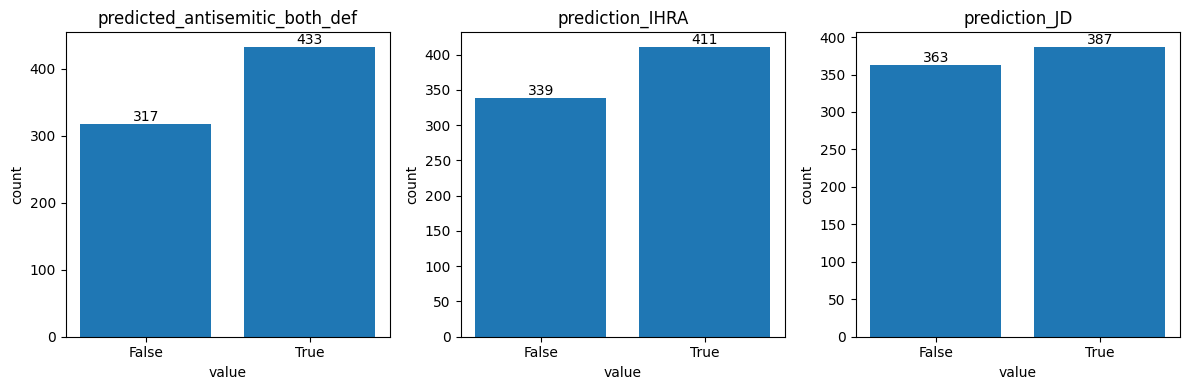

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def bar_counts_same_figure(df, columns, include_na=True, figsize=None):
    n = len(columns)
    if figsize is None:
        figsize = (4*n, 4)

    fig, axes = plt.subplots(1, n, figsize=figsize, squeeze=False)
    axes = axes[0]

    for ax, col in zip(axes, columns):
        s = df[col]
        s = s.fillna("NA") if include_na else s.dropna()
        s = s.astype(bool)
        counts = s.astype(str).value_counts(dropna=False)

        # Nice ordering for boolean-like cols
        labels = counts.index.tolist()
        if set(labels).issubset({"True", "False", "NA"}):
            order = [x for x in ["False", "True", "NA"] if x in labels]
            counts = counts.reindex(order)

        ax.bar(counts.index.tolist(), counts.values.tolist())
        ax.set_title(col)
        ax.set_xlabel("value")
        ax.set_ylabel("count")
        ax.set_xticks(np.arange(len(counts.index)))
        ax.set_xticklabels(counts.index.tolist(), rotation=0)

        # Annotate counts above bars
        for i, v in enumerate(counts.values.tolist()):
            ax.text(i, v, str(v), ha="center", va="bottom")

    plt.tight_layout()
    return fig, axes

# usage
cols = ["predicted_antisemitic_both_def", "prediction_IHRA", "prediction_JD"]
fig, axes = bar_counts_same_figure(merged_df, cols, include_na=True)
plt.show()


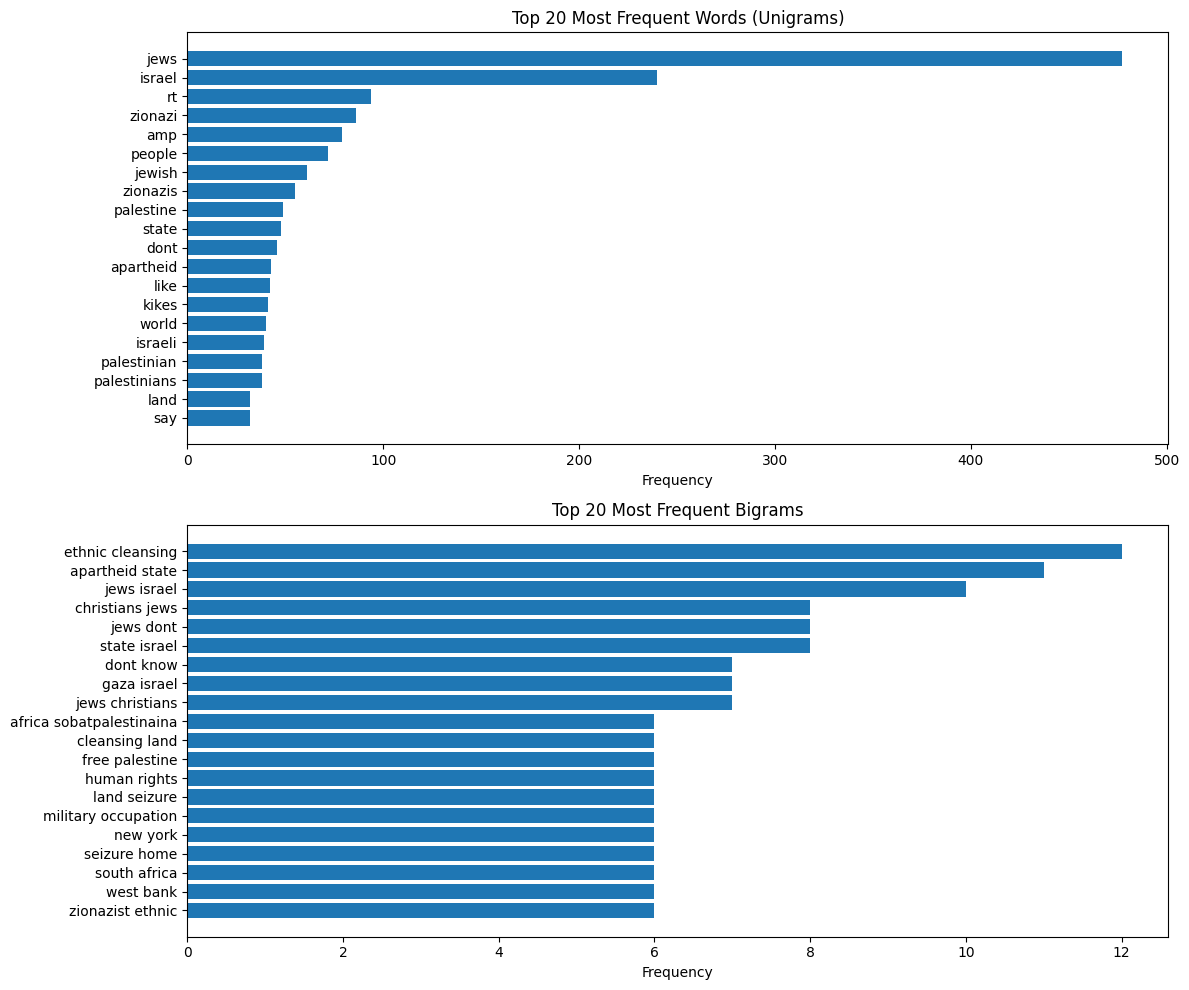

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer


# Clean and prepare text data
def clean_text(text):
    # Convert to lowercase, remove URLs, mentions, and special characters
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    return text.strip()


# Clean all text
df["text_clean"] = df["text"].apply(clean_text)

# Get most frequent words (unigrams)
vectorizer_unigrams = CountVectorizer(
    stop_words="english", max_features=20, ngram_range=(1, 1)
)
unigram_matrix = vectorizer_unigrams.fit_transform(df["text_clean"])
unigram_counts = unigram_matrix.sum(axis=0).A1
unigram_freq = [
    (word, count)
    for word, count in zip(vectorizer_unigrams.get_feature_names_out(), unigram_counts)
]
unigram_freq = sorted(unigram_freq, key=lambda x: x[1], reverse=True)

# Get most frequent bigrams
vectorizer_bigrams = CountVectorizer(
    stop_words="english", max_features=20, ngram_range=(2, 2)
)
bigram_matrix = vectorizer_bigrams.fit_transform(df["text_clean"])
bigram_counts = bigram_matrix.sum(axis=0).A1
bigram_freq = [
    (word, count)
    for word, count in zip(vectorizer_bigrams.get_feature_names_out(), bigram_counts)
]
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

# Create plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot unigrams
words, counts = zip(*unigram_freq)
ax1.barh(range(len(words)), counts)
ax1.set_yticks(range(len(words)))
ax1.set_yticklabels(words)
ax1.set_xlabel("Frequency")
ax1.set_title("Top 20 Most Frequent Words (Unigrams)")
ax1.invert_yaxis()

# Plot bigrams
bigrams, bigram_counts = zip(*bigram_freq)
ax2.barh(range(len(bigrams)), bigram_counts)
ax2.set_yticks(range(len(bigrams)))
ax2.set_yticklabels(bigrams)
ax2.set_xlabel("Frequency")
ax2.set_title("Top 20 Most Frequent Bigrams")
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Prediction stats
A reminder, we gave the LLM the following prompt:


CLASSIFIER_SYSTEM_ONE_DEF = """You are a careful text classifier.

You will be given:
- The definition of antisemitism by <DEFINITION_NAME_PLACEHOLDER>
- a "text" string to classify
Task:
- You should classify if the text is antisemitic according to the given definition.
- The optional labels are: True (antisemitic by definition), False (not antisemitic by definition).
- Pick exactly one label.
- Output JSON only, no extra words.

Output schema:
{
  "answer": "<one key from annotations>",
  "description": "<1 to 3 sentences explaining the choice>"
}

Rules:
- Forget all other definitions of antisemitism, except the one by <DEFINITION_NAME_PLACEHOLDER>.
- answer MUST be exactly True or False
- description must cite concrete cues from the text
"""


USER_PROMPT =  ```"annotations:\n"
        + <ANNOTATIONS GUIDELINES>
        + "\n\ntext:\n"
        + text
        + "\n\nRespond with JSON only matching the schema."
        ```

In [23]:
original_text = pd.read_csv(f"{PROJECT_ROOT}/datasets/GoldStanderDataSet.csv",encoding="cp1252", low_memory=False)
original_text = original_text.rename(columns={"Text": "original_text"})
original_text = original_text.reset_index().rename(columns={"index": "original_index"})

original_text = original_text[["original_index", "original_text", "Username"]]


In [25]:
to_manual_review = merged_df[['original_index', 'text', 'is_antisemitic', 'keyword', 
        'prediction_both_def','description',
       'prediction_IHRA', 'description_IHRA', 'prediction_JD',
       'description_JD']]

to_manual_review["error_by_ihra"] = to_manual_review["is_antisemitic"] != to_manual_review["prediction_IHRA"]
to_manual_review["error_by_jd"] = to_manual_review["is_antisemitic"] != to_manual_review["prediction_JD"]
to_manual_review["is_antisemitic"] = to_manual_review["is_antisemitic"].astype(bool)
to_manual_review = pd.merge(to_manual_review, original_text, on="original_index", how="left")
to_manual_review.to_csv(f"{PROJECT_ROOT}/outputs/twitter_posts_to_manual_review.csv", index=False)

/var/folders/yc/2ky7xhns66nbhnjkcrs4p1nw0000gp/T/ipykernel_65847/3580491828.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_manual_review["error_by_ihra"] = to_manual_review["is_antisemitic"] != to_manual_review["prediction_IHRA"]
/var/folders/yc/2ky7xhns66nbhnjkcrs4p1nw0000gp/T/ipykernel_65847/3580491828.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_manual_review["error_by_jd"] = to_manual_review["is_antisemitic"] != to_manual_review["prediction_JD"]
/var/folders/yc/2ky7xhns66nbhnjkcrs4p1nw

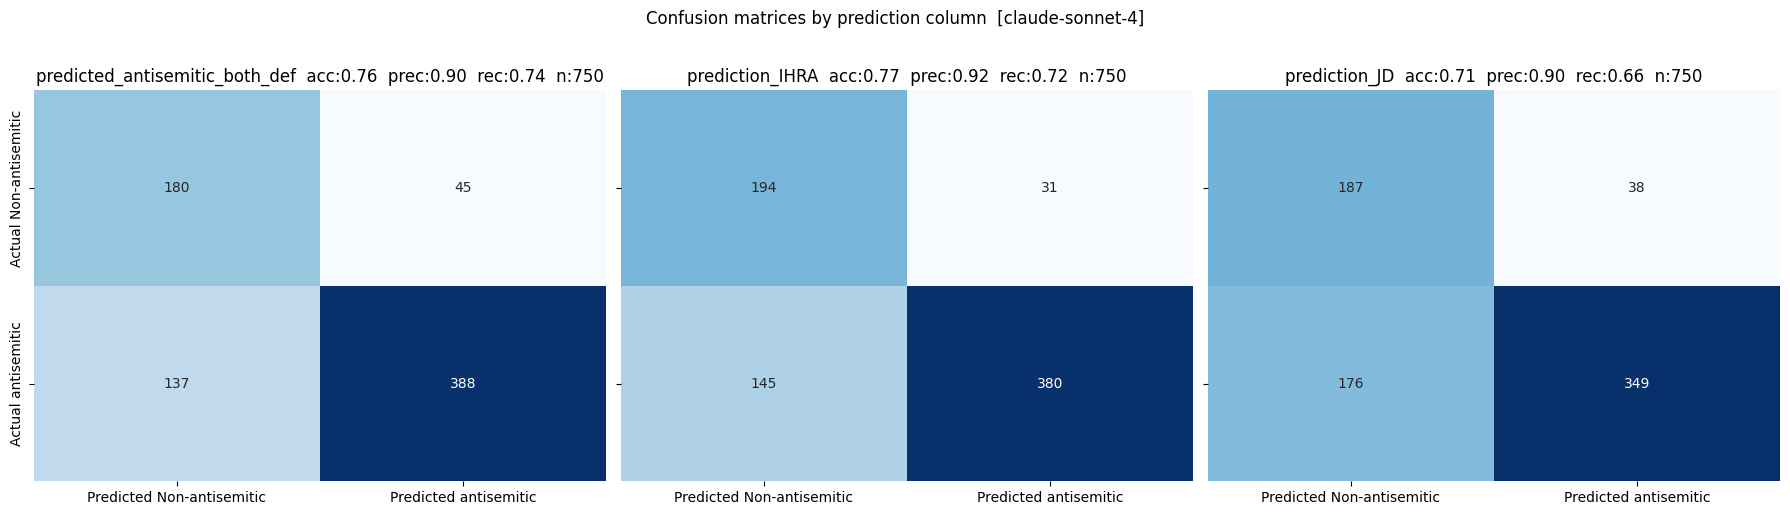

                         pred_col  accuracy  precision    recall
0  predicted_antisemitic_both_def  0.757333   0.896074  0.739048
1                 prediction_IHRA  0.765333   0.924574  0.723810
2                   prediction_JD  0.714667   0.901809  0.664762


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

PRED_COLS = [
    "predicted_antisemitic_both_def",
    "prediction_IHRA",
    "prediction_JD",
]
TRUTH_COL = "is_antisemitic"

def coerce_to_binary(s: pd.Series) -> pd.Series:
    """
    Convert common truthy/falsey values to {0,1}, keep unknowns as NaN.
    Handles bools, 0/1, and strings like 'true','false','yes','no'.
    """
    if s.dtype == bool:
        return s.astype(int)
    if pd.api.types.is_numeric_dtype(s):
        return pd.to_numeric(s, errors="coerce").round().clip(0, 1).astype("Int64")
    # strings
    true_vals = {"true", "1", "yes", "y", "t", "antisemitic"}
    false_vals = {"false", "0", "no", "n", "f", "non-antisemitic", "not antisemitic"}
    ss = s.astype(str).str.strip().str.lower()
    mapped = ss.map(lambda x: 1 if x in true_vals else (0 if x in false_vals else np.nan))
    return pd.Series(mapped, index=s.index, dtype="float")

def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    return cm, precision, recall, accuracy

# Prepare truth once
y_true_all = coerce_to_binary(df[TRUTH_COL])

metrics_rows = []
n = len(PRED_COLS)
fig, axes = plt.subplots(1, n, figsize=(6*n, 5), sharex=True, sharey=True)

# Optional: show model name if available
model_name = None
if "model" in df.columns and df["model"].notna().any():
    try:
        model_name = df["model"].dropna().iloc[0].split("/")[-1]
    except Exception:
        model_name = df["model"].dropna().iloc[0]

for ax, col in zip(axes, PRED_COLS):
    y_pred_all = coerce_to_binary(merged_df[col])

    # Align and drop rows with NaNs in either
    mask = (~pd.isna(y_true_all)) & (~pd.isna(y_pred_all))
    y_true = y_true_all[mask].astype(int)
    y_pred = y_pred_all[mask].astype(int)

    cm, precision, recall, accuracy = calculate_metrics(y_true, y_pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Predicted Non-antisemitic", "Predicted antisemitic"],
        yticklabels=["Actual Non-antisemitic", "Actual antisemitic"],
        ax=ax,
    )
    title_bits = [col, f"acc:{accuracy:.2f}", f"prec:{precision:.2f}", f"rec:{recall:.2f}", f"n:{int(mask.sum())}"]
    ax.set_title("  ".join(title_bits))
    ax.set_xlabel("")
    ax.set_ylabel("")

    metrics_rows.append(
        {
            "pred_col": col,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
        }
    )

if model_name:
    fig.suptitle(f"Confusion matrices by prediction column  [{model_name}]", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

metrics_df = pd.DataFrame(metrics_rows)
print(metrics_df)


In [8]:
import numpy as np
df_only_true_pred = merged_df[(merged_df["is_antisemitic"] == 1)].copy()
# # Coerce to booleans safely
ihra = df_only_true_pred["prediction_IHRA"].astype(str).str.lower().isin(["true", "1", "yes"])
jd   = df_only_true_pred["prediction_JD"].astype(str).str.lower().isin(["true", "1", "yes"])

df_only_true_pred["antisemitic_type"] = np.select(
    [ihra & jd, ihra & ~jd, ~ihra & jd],
    ["IHRA_JD", "IHRA", "JD"],
    default="None"
)

# quick sanity check
df_only_true_pred["antisemitic_type"].value_counts(dropna=False)


antisemitic_type
IHRA_JD    340
None       136
IHRA        40
JD           9
Name: count, dtype: int64

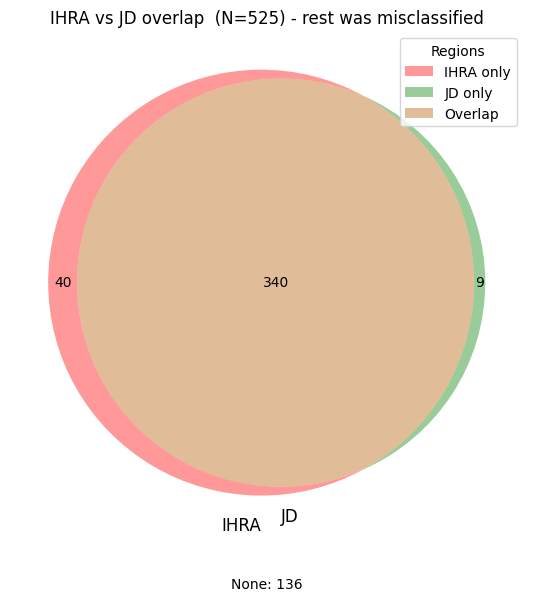

(<Figure size 600x600 with 1 Axes>,
 <matplotlib_venn._common.VennDiagram at 0x12f0f3590>)

In [9]:
from matplotlib_venn import venn2

def plot_antisemitic_type_venn(df, type_col="antisemitic_type", show_pct=False):
    vc = df[type_col].value_counts(dropna=False)

    ihra_only = int(vc.get("IHRA", 0))
    jd_only   = int(vc.get("JD", 0))
    both      = int(vc.get("IHRA_JD", 0))
    none      = int(vc.get("None", 0))
    total     = ihra_only + jd_only + both + none

    fig, ax = plt.subplots(figsize=(6, 6))
    v = venn2(
        subsets=(ihra_only, jd_only, both),
        set_labels=("IHRA", "JD"),
        ax=ax
    )

    # Label counts or percentages inside regions
    def fmt(x): return f"{x} ({x/total:.0%})" if show_pct and total else str(x)
    if v.get_label_by_id("10"): v.get_label_by_id("10").set_text(fmt(ihra_only))
    if v.get_label_by_id("01"): v.get_label_by_id("01").set_text(fmt(jd_only))
    if v.get_label_by_id("11"): v.get_label_by_id("11").set_text(fmt(both))

    # Outside count
    ax.text(0.5, -0.10, f"None: {fmt(none)}", ha="center", va="center", transform=ax.transAxes)

    # Legend using the actual colored patches
    handles, labels = [], []
    if v.get_patch_by_id("10"):
        handles.append(v.get_patch_by_id("10")); labels.append("IHRA only")
    if v.get_patch_by_id("01"):
        handles.append(v.get_patch_by_id("01")); labels.append("JD only")
    if v.get_patch_by_id("11"):
        handles.append(v.get_patch_by_id("11")); labels.append("Overlap")

    if handles:
        ax.legend(handles, labels, loc="upper right", frameon=True, title="Regions")

    ax.set_title(f"IHRA vs JD overlap  (N={total}) - rest was misclassified")
    plt.tight_layout()
    plt.show()
    return fig, v

plot_antisemitic_type_venn(df_only_true_pred)


In [10]:
from itables import show
import itables.options as opt
from IPython.display import HTML, display

opt.classes = ["display", "cell-border", "compact"]


display(
    HTML("""
<style>
table.dataTable { table-layout: fixed; }               /* column widths are respected */
table.dataTable td { white-space: normal;              /* allow wrapping */
                     word-break: break-word;           /* break long tokens */
                     overflow-wrap: anywhere; }
</style>
""")
)


opt.autoWidth = True
coldefs = [{"width": "280px", "targets": ["text", "description_IHRA", "description_IHRA"]}]


opt.lengthMenu = [10, 25, 50, 100]
opt.maxBytes = 0

In [11]:
relevant_cols = ["text","prediction_IHRA", "description_IHRA", "prediction_JD","description_JD"]
only_jd = df_only_true_pred[df_only_true_pred["antisemitic_type"]=="JD"]
show(only_jd[relevant_cols], caption="Only JD classified as antisemitic")

Loading ITables v2.5.2 from the internet... (need help?)


In [12]:
relevant_cols = ["text","prediction_IHRA", "description_IHRA", "prediction_JD","description_JD"]
only_hira = df_only_true_pred[df_only_true_pred["antisemitic_type"]=="IHRA"]
show(only_hira[relevant_cols], caption="Only IHRA classified as antisemitic")

Loading ITables v2.5.2 from the internet... (need help?)
